# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

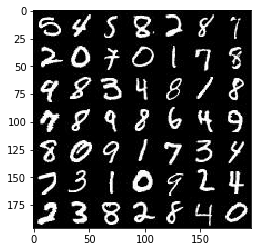

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

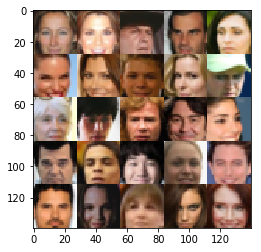

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(dtype = tf.float32, shape = [None, image_height, image_width, image_channels], name = 'real_inputs')
    generation_seeds = tf.placeholder(dtype = tf.float32, shape = [None, z_dim], name = 'generation_seeds')
    learning_rate = tf.placeholder(dtype = tf.float32, name = 'learning_rate')

    return real_inputs, generation_seeds, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse = False, alpha = 0.01, drop_rate = 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    is_train = not reuse
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        h, w, c = 28, 28, 4  # Input
                
        disc_flow = tf.layers.conv2d(
            inputs = images, 
            filters = 64, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same')
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 14, 14, 64
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 32, 
            kernel_size = 5, 
            strides = 2,
            padding = 'same') 
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = is_train)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 7, 7, 32
        
        disc_flow = tf.layers.conv2d(
            inputs = disc_flow, 
            filters = 16, 
            kernel_size = 3, 
            strides = 1,
            padding = 'same')
        disc_flow = tf.layers.batch_normalization(
            inputs = disc_flow, 
            training = is_train)
        disc_flow = tf.maximum(alpha * disc_flow, disc_flow)
        disc_flow = tf.layers.dropout(inputs = disc_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 7, 7, 16
        
        disc_flow = tf.reshape(tensor = disc_flow, shape = [-1, h * w * c])
        disc_flow = tf.layers.dense(
            inputs = disc_flow, 
            units = 1)
        output = tf.tanh(disc_flow)
        
    return output, disc_flow

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01, drop_rate = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse = not is_train):
    
        h, w, c = 7, 7, 128  # Start

        gen_flow = tf.layers.dense(
            inputs = z,
            units = h * w * c)
        gen_flow = tf.reshape(
            tensor = gen_flow, 
            shape = [-1, h, w, c])
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)

        h, w, c = 7, 7, 128

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 65, 
            kernel_size = 3, 
            strides = 1, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate, seed = 17)

        h, w, c = 7, 7, 64

        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 32, 
            kernel_size = 3, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 14, 14, 32
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = 16, 
            kernel_size = 5, 
            strides = 2, 
            padding = 'same')
        gen_flow = tf.layers.batch_normalization(
            inputs = gen_flow, 
            training = is_train)
        gen_flow = tf.maximum(alpha * gen_flow, gen_flow)
        gen_flow = tf.layers.dropout(inputs = gen_flow, training = is_train, rate = drop_rate, seed = 17)
        
        h, w, c = 28, 28, 16
        
        gen_flow = tf.layers.conv2d_transpose(
            inputs = gen_flow, 
            filters = out_channel_dim, 
            kernel_size = 7, 
            strides = 1, 
            padding = 'same')
        
        h, w, c = 28, 28, out_channel_dim
        
        out = tf.tanh(gen_flow)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.01, drop_rate = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # input_real = tf.multiply(input_real, 2)  # Scale input images by 2 from [-.5,.5] -> [-1,1]

    g_out = generator(z = input_z, out_channel_dim = out_channel_dim, is_train = True, alpha = alpha)
    d_real_out, d_real_layer = discriminator(images = input_real, reuse = False, alpha = alpha)
    d_fake_out, d_fake_layer = discriminator(images = g_out, reuse = True, alpha = alpha)
    
    g_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.ones_like(d_fake_out)))
    
    d_real_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_real_layer, 
            labels = tf.ones_like(d_real_out)))
    d_fake_loss = tf.reduce_mean(
        input_tensor = tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_fake_layer, 
            labels = tf.zeros_like(d_fake_out)))

    d_loss = d_real_loss + d_fake_loss

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, drop_rate = 0.1, alpha = 0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    tf.reset_default_graph()
    
    real_inputs, generation_seeds, lr = model_inputs(
        image_width = data_shape[1], 
        image_height =  data_shape[2], 
        image_channels = data_shape[3], 
        z_dim = z_dim)
    
    d_loss, g_loss = model_loss(
        input_real = real_inputs, 
        input_z = generation_seeds, 
        out_channel_dim = data_shape[3], 
        alpha = alpha,
        drop_rate = drop_rate)

    g_opt, d_opt = model_opt(
        d_loss = d_loss, 
        g_loss = g_loss, 
        learning_rate = lr, 
        beta1 = beta1)    

    steps = 0
    # saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for x in get_batches(batch_size):
                
                steps += 1

                z = np.random.uniform(low = -1, high = 1, size = [batch_size, z_dim])

                feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate}
                
                # _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(d_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict = {real_inputs: x, generation_seeds: z, lr: learning_rate})

                if steps % 16 == 0:
                    
                    d_train_loss = d_loss.eval({generation_seeds: z, real_inputs: x})
                    g_train_loss = g_loss.eval({generation_seeds: z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "D Loss: {:.4f}...".format(d_train_loss),
                          "G Loss: {:.4f}".format(g_train_loss))
                    
                if steps % 128 == 0:
                    
                    show_generator_output(
                        sess = sess, 
                        n_images = 25, 
                        input_z = generation_seeds, 
                        out_channel_dim = data_shape[3], 
                        image_mode = data_image_mode)

        # saver.save(sess, './checkpoints/generator.ckpt')                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... D Loss: 0.5893... G Loss: 0.8564
Epoch 1/2... D Loss: 0.0590... G Loss: 3.0553
Epoch 1/2... D Loss: 0.0248... G Loss: 3.9832
Epoch 1/2... D Loss: 0.0165... G Loss: 4.6014
Epoch 1/2... D Loss: 0.0092... G Loss: 5.5366
Epoch 1/2... D Loss: 0.0062... G Loss: 5.9901
Epoch 1/2... D Loss: 0.0049... G Loss: 6.5370
Epoch 1/2... D Loss: 0.0045... G Loss: 6.4725


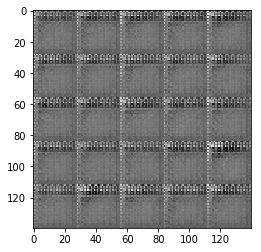

Epoch 1/2... D Loss: 0.0039... G Loss: 6.7420
Epoch 1/2... D Loss: 0.0028... G Loss: 6.8417
Epoch 1/2... D Loss: 0.0028... G Loss: 7.1333
Epoch 1/2... D Loss: 0.0025... G Loss: 7.1885
Epoch 1/2... D Loss: 0.0019... G Loss: 7.2765
Epoch 1/2... D Loss: 0.0020... G Loss: 7.3349
Epoch 1/2... D Loss: 0.0017... G Loss: 7.4174
Epoch 1/2... D Loss: 0.0015... G Loss: 7.5246


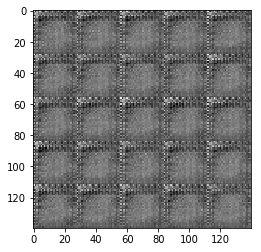

Epoch 1/2... D Loss: 0.0013... G Loss: 7.5420
Epoch 1/2... D Loss: 0.0015... G Loss: 7.4638
Epoch 1/2... D Loss: 0.0016... G Loss: 7.3680
Epoch 1/2... D Loss: 0.0014... G Loss: 7.3406
Epoch 1/2... D Loss: 0.0013... G Loss: 7.3499
Epoch 1/2... D Loss: 0.0014... G Loss: 7.4208
Epoch 1/2... D Loss: 0.0013... G Loss: 7.5002
Epoch 1/2... D Loss: 0.0010... G Loss: 7.7332


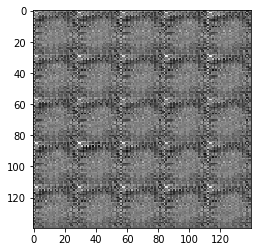

Epoch 1/2... D Loss: 0.0009... G Loss: 7.9424
Epoch 1/2... D Loss: 0.0008... G Loss: 7.9917
Epoch 1/2... D Loss: 0.0008... G Loss: 7.9663
Epoch 1/2... D Loss: 0.0010... G Loss: 7.9528
Epoch 1/2... D Loss: 0.0009... G Loss: 8.0637
Epoch 1/2... D Loss: 0.0008... G Loss: 8.0792
Epoch 1/2... D Loss: 0.0008... G Loss: 8.0171
Epoch 1/2... D Loss: 0.0007... G Loss: 7.9016


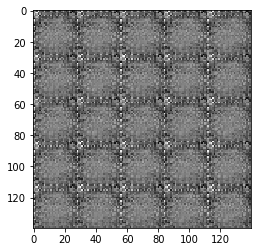

Epoch 1/2... D Loss: 0.0009... G Loss: 7.8207
Epoch 1/2... D Loss: 0.0009... G Loss: 7.8425
Epoch 1/2... D Loss: 0.0011... G Loss: 7.8253
Epoch 1/2... D Loss: 0.0010... G Loss: 7.8677
Epoch 1/2... D Loss: 0.0008... G Loss: 7.9552
Epoch 1/2... D Loss: 0.0007... G Loss: 8.0817
Epoch 1/2... D Loss: 0.0007... G Loss: 8.1701
Epoch 1/2... D Loss: 0.0006... G Loss: 8.1357


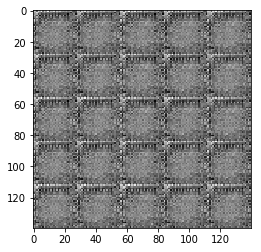

Epoch 1/2... D Loss: 0.0009... G Loss: 8.1446
Epoch 1/2... D Loss: 0.0006... G Loss: 8.1745
Epoch 1/2... D Loss: 0.0006... G Loss: 8.1215
Epoch 1/2... D Loss: 0.0009... G Loss: 8.1151
Epoch 1/2... D Loss: 0.0006... G Loss: 8.0809
Epoch 1/2... D Loss: 0.0007... G Loss: 8.1363
Epoch 1/2... D Loss: 0.0006... G Loss: 8.1020
Epoch 1/2... D Loss: 0.0006... G Loss: 8.2227


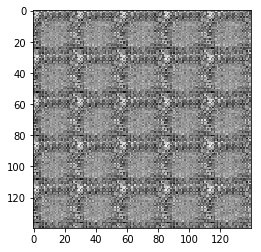

Epoch 1/2... D Loss: 0.0005... G Loss: 8.3539
Epoch 1/2... D Loss: 0.0005... G Loss: 8.4785
Epoch 1/2... D Loss: 0.0005... G Loss: 8.7082
Epoch 1/2... D Loss: 0.0004... G Loss: 8.7210
Epoch 1/2... D Loss: 0.0004... G Loss: 8.5532
Epoch 1/2... D Loss: 0.0004... G Loss: 8.4106
Epoch 1/2... D Loss: 0.0017... G Loss: 8.3173
Epoch 1/2... D Loss: 0.0006... G Loss: 8.2480


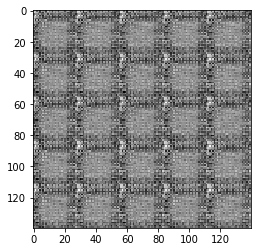

Epoch 1/2... D Loss: 0.0005... G Loss: 8.2796
Epoch 1/2... D Loss: 0.0005... G Loss: 8.2792
Epoch 1/2... D Loss: 0.0009... G Loss: 8.3946
Epoch 1/2... D Loss: 0.0003... G Loss: 8.5455
Epoch 1/2... D Loss: 0.0005... G Loss: 8.6207
Epoch 1/2... D Loss: 0.0004... G Loss: 8.5924
Epoch 1/2... D Loss: 0.0003... G Loss: 8.7907
Epoch 1/2... D Loss: 0.0003... G Loss: 8.7801


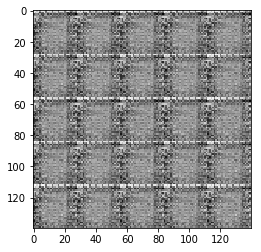

Epoch 1/2... D Loss: 0.0003... G Loss: 8.6698
Epoch 1/2... D Loss: 0.0005... G Loss: 8.5992
Epoch 1/2... D Loss: 0.0004... G Loss: 8.5245
Epoch 1/2... D Loss: 0.0005... G Loss: 8.5890
Epoch 1/2... D Loss: 0.0004... G Loss: 8.4955
Epoch 1/2... D Loss: 0.0004... G Loss: 8.5803
Epoch 1/2... D Loss: 0.0003... G Loss: 8.7020
Epoch 1/2... D Loss: 0.0004... G Loss: 8.6908


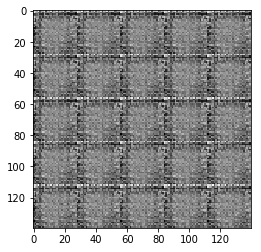

Epoch 1/2... D Loss: 0.0004... G Loss: 8.7011
Epoch 1/2... D Loss: 0.0003... G Loss: 8.8063
Epoch 1/2... D Loss: 0.0003... G Loss: 8.9829
Epoch 1/2... D Loss: 0.0003... G Loss: 9.1398
Epoch 1/2... D Loss: 0.0003... G Loss: 9.1227
Epoch 1/2... D Loss: 0.0003... G Loss: 8.9546
Epoch 1/2... D Loss: 0.0002... G Loss: 8.8452
Epoch 1/2... D Loss: 0.0003... G Loss: 8.8761


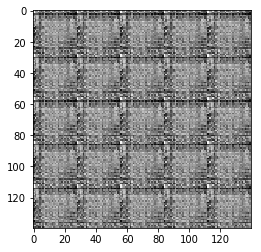

Epoch 1/2... D Loss: 0.0003... G Loss: 8.8510
Epoch 1/2... D Loss: 0.0003... G Loss: 8.7989
Epoch 1/2... D Loss: 0.0003... G Loss: 8.8246
Epoch 1/2... D Loss: 0.0003... G Loss: 8.9372
Epoch 1/2... D Loss: 0.0004... G Loss: 9.1074
Epoch 1/2... D Loss: 0.0004... G Loss: 8.9484
Epoch 1/2... D Loss: 0.0003... G Loss: 8.8785
Epoch 1/2... D Loss: 0.0004... G Loss: 8.9297


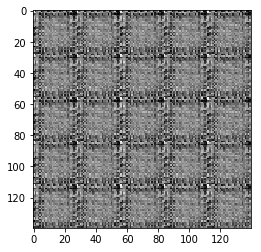

Epoch 1/2... D Loss: 0.0002... G Loss: 8.9229
Epoch 1/2... D Loss: 0.0004... G Loss: 8.7580
Epoch 1/2... D Loss: 0.0002... G Loss: 8.8277
Epoch 1/2... D Loss: 0.0003... G Loss: 8.9913
Epoch 1/2... D Loss: 0.0002... G Loss: 8.9223
Epoch 1/2... D Loss: 0.0002... G Loss: 9.0989
Epoch 1/2... D Loss: 0.0002... G Loss: 9.0266
Epoch 1/2... D Loss: 0.0002... G Loss: 9.2255


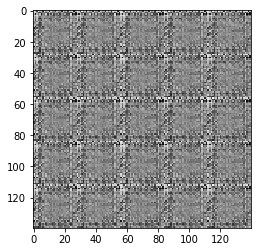

Epoch 1/2... D Loss: 0.0002... G Loss: 9.3063
Epoch 1/2... D Loss: 0.0003... G Loss: 9.2475
Epoch 1/2... D Loss: 0.0003... G Loss: 9.2532
Epoch 1/2... D Loss: 0.0002... G Loss: 8.9724
Epoch 1/2... D Loss: 0.0002... G Loss: 9.0949
Epoch 1/2... D Loss: 0.0002... G Loss: 9.0158
Epoch 1/2... D Loss: 0.0003... G Loss: 9.0303
Epoch 1/2... D Loss: 0.0002... G Loss: 9.3328


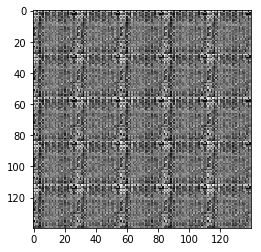

Epoch 1/2... D Loss: 0.0004... G Loss: 9.0790
Epoch 1/2... D Loss: 0.0003... G Loss: 9.0025
Epoch 1/2... D Loss: 0.0003... G Loss: 9.0123
Epoch 1/2... D Loss: 0.0002... G Loss: 9.4438
Epoch 1/2... D Loss: 0.0003... G Loss: 9.0676
Epoch 1/2... D Loss: 0.0003... G Loss: 9.0144
Epoch 1/2... D Loss: 0.0002... G Loss: 9.4529
Epoch 1/2... D Loss: 0.0004... G Loss: 9.0191


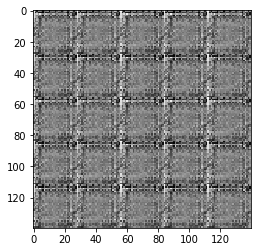

Epoch 1/2... D Loss: 0.0002... G Loss: 9.1389
Epoch 1/2... D Loss: 0.0003... G Loss: 9.0759
Epoch 1/2... D Loss: 0.0003... G Loss: 8.8760
Epoch 1/2... D Loss: 0.0003... G Loss: 9.0529
Epoch 1/2... D Loss: 0.0003... G Loss: 9.1681
Epoch 2/2... D Loss: 0.0002... G Loss: 9.0241
Epoch 2/2... D Loss: 0.0003... G Loss: 8.7988
Epoch 2/2... D Loss: 0.0003... G Loss: 9.2367


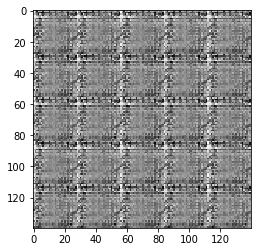

Epoch 2/2... D Loss: 0.0003... G Loss: 8.9621
Epoch 2/2... D Loss: 0.0003... G Loss: 8.9505
Epoch 2/2... D Loss: 0.0003... G Loss: 9.2840
Epoch 2/2... D Loss: 0.0004... G Loss: 9.0379
Epoch 2/2... D Loss: 0.0002... G Loss: 9.2260
Epoch 2/2... D Loss: 0.0004... G Loss: 8.9745
Epoch 2/2... D Loss: 0.0002... G Loss: 9.3994
Epoch 2/2... D Loss: 0.0003... G Loss: 9.1704


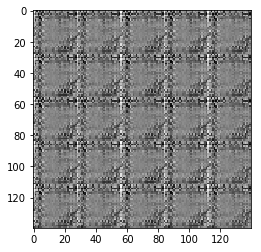

Epoch 2/2... D Loss: 0.0002... G Loss: 9.2886
Epoch 2/2... D Loss: 0.0002... G Loss: 9.1552
Epoch 2/2... D Loss: 0.0002... G Loss: 9.3000
Epoch 2/2... D Loss: 0.0002... G Loss: 9.3709
Epoch 2/2... D Loss: 0.0002... G Loss: 9.0586
Epoch 2/2... D Loss: 0.0002... G Loss: 9.1857
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5044
Epoch 2/2... D Loss: 0.0002... G Loss: 9.0713


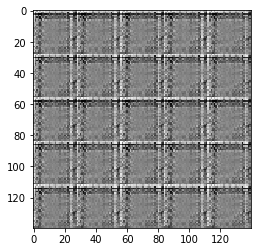

Epoch 2/2... D Loss: 0.0002... G Loss: 9.5467
Epoch 2/2... D Loss: 0.0002... G Loss: 9.3602
Epoch 2/2... D Loss: 0.0002... G Loss: 9.0586
Epoch 2/2... D Loss: 0.0004... G Loss: 9.3415
Epoch 2/2... D Loss: 0.0002... G Loss: 9.1335
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5462
Epoch 2/2... D Loss: 0.0001... G Loss: 9.2886
Epoch 2/2... D Loss: 0.0002... G Loss: 9.6839


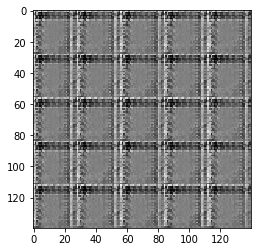

Epoch 2/2... D Loss: 0.0002... G Loss: 9.1895
Epoch 2/2... D Loss: 0.0002... G Loss: 9.4940
Epoch 2/2... D Loss: 0.0002... G Loss: 9.2454
Epoch 2/2... D Loss: 0.0001... G Loss: 9.3106
Epoch 2/2... D Loss: 0.0002... G Loss: 9.2205
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5333
Epoch 2/2... D Loss: 0.0002... G Loss: 9.2077
Epoch 2/2... D Loss: 0.0002... G Loss: 9.5687


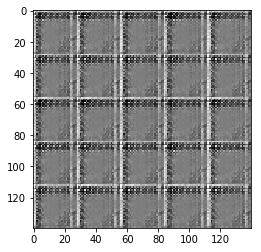

Epoch 2/2... D Loss: 0.0002... G Loss: 9.1963
Epoch 2/2... D Loss: 0.0002... G Loss: 9.7331
Epoch 2/2... D Loss: 0.0002... G Loss: 9.9254
Epoch 2/2... D Loss: 0.0002... G Loss: 9.2963
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5969
Epoch 2/2... D Loss: 0.0003... G Loss: 9.5049
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5662
Epoch 2/2... D Loss: 0.0001... G Loss: 9.3867


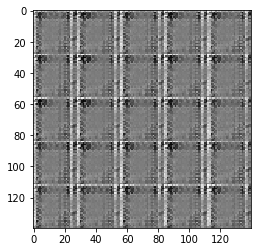

Epoch 2/2... D Loss: 0.0002... G Loss: 9.4366
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5337
Epoch 2/2... D Loss: 0.0001... G Loss: 9.4025
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5775
Epoch 2/2... D Loss: 0.0002... G Loss: 9.1367
Epoch 2/2... D Loss: 0.0002... G Loss: 9.4797
Epoch 2/2... D Loss: 0.0001... G Loss: 9.4001
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5189


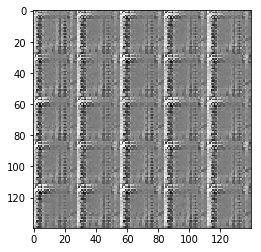

Epoch 2/2... D Loss: 0.0003... G Loss: 9.4405
Epoch 2/2... D Loss: 0.0001... G Loss: 9.3847
Epoch 2/2... D Loss: 0.0001... G Loss: 9.4487
Epoch 2/2... D Loss: 0.0001... G Loss: 9.4207
Epoch 2/2... D Loss: 0.0002... G Loss: 9.5232
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6928
Epoch 2/2... D Loss: 0.0002... G Loss: 9.3890
Epoch 2/2... D Loss: 0.0001... G Loss: 9.9325


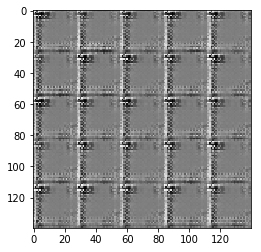

Epoch 2/2... D Loss: 0.0001... G Loss: 9.7370
Epoch 2/2... D Loss: 0.0001... G Loss: 10.3301
Epoch 2/2... D Loss: 0.0001... G Loss: 10.2598
Epoch 2/2... D Loss: 0.0001... G Loss: 9.7211
Epoch 2/2... D Loss: 0.0001... G Loss: 9.4959
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6608
Epoch 2/2... D Loss: 0.0001... G Loss: 10.2410
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5884


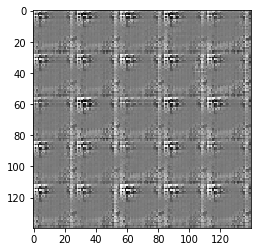

Epoch 2/2... D Loss: 0.0001... G Loss: 9.9741
Epoch 2/2... D Loss: 0.0002... G Loss: 9.5056
Epoch 2/2... D Loss: 0.0001... G Loss: 10.2919
Epoch 2/2... D Loss: 0.0001... G Loss: 9.3836
Epoch 2/2... D Loss: 0.0003... G Loss: 9.8762
Epoch 2/2... D Loss: 0.0002... G Loss: 9.4913
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6540
Epoch 2/2... D Loss: 0.0003... G Loss: 9.7643


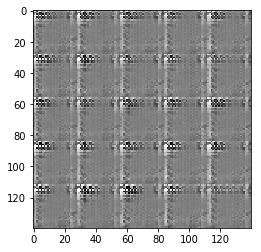

Epoch 2/2... D Loss: 0.0002... G Loss: 9.6417
Epoch 2/2... D Loss: 0.0001... G Loss: 9.7531
Epoch 2/2... D Loss: 0.0001... G Loss: 9.7946
Epoch 2/2... D Loss: 0.0001... G Loss: 9.4738
Epoch 2/2... D Loss: 0.0001... G Loss: 9.7317
Epoch 2/2... D Loss: 0.0008... G Loss: 9.6244
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6366
Epoch 2/2... D Loss: 0.0002... G Loss: 9.7867


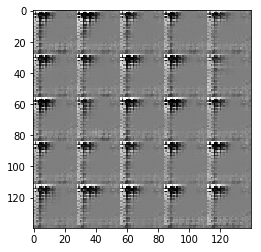

Epoch 2/2... D Loss: 0.0001... G Loss: 9.7905
Epoch 2/2... D Loss: 0.0002... G Loss: 9.5389
Epoch 2/2... D Loss: 0.0002... G Loss: 10.1020
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6153
Epoch 2/2... D Loss: 0.0001... G Loss: 9.7003
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6703
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6633
Epoch 2/2... D Loss: 0.0001... G Loss: 9.9000


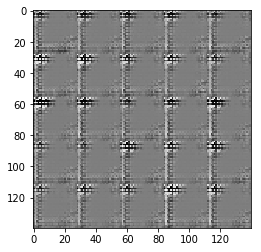

Epoch 2/2... D Loss: 0.0001... G Loss: 9.7378
Epoch 2/2... D Loss: 0.0001... G Loss: 9.8046
Epoch 2/2... D Loss: 0.0001... G Loss: 9.9982
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6265
Epoch 2/2... D Loss: 0.0001... G Loss: 9.8631
Epoch 2/2... D Loss: 0.0001... G Loss: 9.9097
Epoch 2/2... D Loss: 0.0001... G Loss: 9.4790
Epoch 2/2... D Loss: 0.0001... G Loss: 9.6577


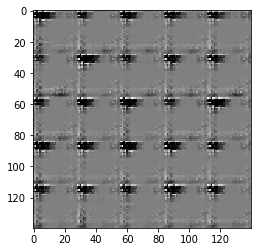

Epoch 2/2... D Loss: 0.0001... G Loss: 9.8350
Epoch 2/2... D Loss: 0.0001... G Loss: 9.8965
Epoch 2/2... D Loss: 0.0001... G Loss: 9.5152
Epoch 2/2... D Loss: 0.0000... G Loss: 34.1165
Epoch 2/2... D Loss: 0.0001... G Loss: 12.4861
Epoch 2/2... D Loss: 0.0001... G Loss: 10.2237
Epoch 2/2... D Loss: 0.0002... G Loss: 9.2680
Epoch 2/2... D Loss: 0.0002... G Loss: 9.9343


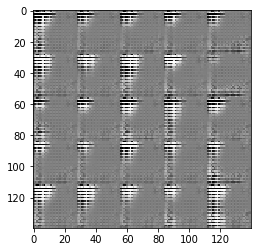

Epoch 2/2... D Loss: 0.0002... G Loss: 9.1860
Epoch 2/2... D Loss: 0.0015... G Loss: 9.2762
Epoch 2/2... D Loss: 0.0002... G Loss: 8.9796
Epoch 2/2... D Loss: 0.0002... G Loss: 9.1041
Epoch 2/2... D Loss: 0.0002... G Loss: 9.1025
Epoch 2/2... D Loss: 0.0002... G Loss: 9.0499
Epoch 2/2... D Loss: 0.0001... G Loss: 9.1935
Epoch 2/2... D Loss: 0.0002... G Loss: 9.0372


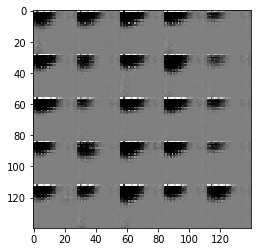

Epoch 2/2... D Loss: 0.0002... G Loss: 9.1722
Epoch 2/2... D Loss: 0.0001... G Loss: 9.2027


IndexError: list index out of range

In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5
drop_rate = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha = alpha, drop_rate = drop_rate)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
alpha = 0.2
beta1 = .5
drop_rate = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha = alpha, drop_rate = drop_rate)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.